
# Step 7 — Local Interpretability with SHAP (on XGBoost)

This notebook explains individual predictions of the **Step 2 XGBoost model** using **SHAP**.
It loads your fitted model pipeline from `outputs_step2/xgb_step2_model.joblib`, recreates the minimal preprocessing (for safety), and generates global & local SHAP plots.

**Outputs** are saved in `outputs_step7/`.


## 0) Setup

In [6]:

# If needed, install once:
# %pip install -q shap

import os, sys, platform, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap
import joblib

print("Python:", platform.python_version())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

import sklearn, xgboost
print("scikit-learn:", sklearn.__version__)
print("XGBoost:", xgboost.__version__)
print("SHAP:", shap.__version__)

# Output dir
os.makedirs("outputs_step7", exist_ok=True)

# Enable JS for force plots in-notebook (optional)
shap.initjs()


Python: 3.12.1
NumPy: 2.3.3
Pandas: 2.3.2
scikit-learn: 1.7.2
XGBoost: 3.0.5
SHAP: 0.48.0


## 1) Configuration

In [10]:

# Paths
MODEL_PATH_CANDIDATES = [
"/Users/berdup/Desktop/Algo-Fairness-Group-Project/Algo_fairness-Group-Project/reports/artifacts/xgb_step2_model.joblib"
]
DATA_PATH_CANDIDATES = [
"/Users/berdup/Desktop/Algo-Fairness-Group-Project/Algo_fairness-Group-Project/dataproject2025.csv"

]

def first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return paths[0]

MODEL_PATH = first_existing(MODEL_PATH_CANDIDATES)
DATA_PATH  = first_existing(DATA_PATH_CANDIDATES)

# Run parameters
USE_SAMPLE = True      # set False for full run
SAMPLE_N   = 25000     # rows for quick SHAP
BG_N       = 2000      # background size for SHAP explainer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("MODEL_PATH:", MODEL_PATH)
print("DATA_PATH :", DATA_PATH)


MODEL_PATH: /Users/berdup/Desktop/Algo-Fairness-Group-Project/Algo_fairness-Group-Project/reports/artifacts/xgb_step2_model.joblib
DATA_PATH : /Users/berdup/Desktop/Algo-Fairness-Group-Project/Algo_fairness-Group-Project/dataproject2025.csv


## 2) Helper class for the saved pipeline

In [11]:

# The Step 2 model was saved as a Pipeline with a custom 'PretrainedPreprocessor' wrapper.
# We re-declare it here so joblib can unpickle the model.
from sklearn.base import BaseEstimator, TransformerMixin

class PretrainedPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, fitted_preprocessor):
        self.fitted = fitted_preprocessor
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return self.fitted.transform(X)


## 3) Load trained model and components

In [12]:

final_model = joblib.load(MODEL_PATH)

# Unpack components
pipeline_steps = final_model.named_steps
prep_wrapper   = pipeline_steps["prep"]            # PretrainedPreprocessor
prep           = prep_wrapper.fitted               # fitted ColumnTransformer
xgb            = pipeline_steps["xgb"]             # fitted XGBClassifier

print("Loaded model. Booster params:", xgb.get_params())


Loaded model. Booster params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 1.0, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1200, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'sampling_method': None, 'scale_pos_weight': 3.7506970336434904, 'subsample': 0.8, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


## 4) Load raw data and minimal cleaning (align with Step 2)

In [13]:

# Read data
df = pd.read_csv(DATA_PATH, low_memory=False)

# Drop known leaky / index columns (from Step 2)
LEAKY_COLS = [
    "Predictions", "Predicted probabilities", "DP", "dp",
    "Unnamed: 0", "id", "ID", "index"
]
df = df.drop(columns=[c for c in LEAKY_COLS if c in df.columns], errors="ignore")

# Clean infinities
df = df.replace([np.inf, -np.inf], np.nan)

# Ensure Step 2 engineered columns exist if the model expects them
def parse_emp_length(val):
    if pd.isna(val): return np.nan
    s = str(val).strip().lower()
    if s in {"< 1 year", "less than 1 year", "<1 year"}: return 0.5
    if s in {"10+ years", "10+ yrs", "10+yr"}: return 10.0
    for tok in s.replace("+","").split():
        try: return float(int(tok))
        except: continue
    try: return float(s)
    except: return np.nan

def parse_loan_duration(val):
    if pd.isna(val): return np.nan
    if isinstance(val, (int, float)): return float(val)
    s = str(val).strip().lower().replace("months","").replace("month","").strip()
    try: return float(s)
    except: return np.nan

if "emp_length" in df.columns and "emp_length_parsed" not in df.columns:
    df["emp_length_parsed"] = df["emp_length"].apply(parse_emp_length)

if "loan duration" in df.columns and "loan_duration_parsed" not in df.columns:
    df["loan_duration_parsed"] = df["loan duration"].apply(parse_loan_duration)

if "issue_d" in df.columns and "issue_d_ordinal" not in df.columns:
    if df["issue_d"].dtype == object:
        d = pd.to_datetime(df["issue_d"], errors="coerce")
        df["issue_d_ordinal"] = d.map(lambda x: x.toordinal() if pd.notna(x) else np.nan)

print("Raw shape:", df.shape)
display(df.head(2))


Raw shape: (1086683, 38)


,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,emp_length_parsed,loan_duration_parsed
0,2013.0,0.0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,...,home_improvement,4136.0,16.1,B2,0.0,0.0,782.0,7.388592,2.0,0.0
1,2013.0,0.0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,...,debt_consolidation,36638.0,61.2,B2,0.0,0.0,481.0,9.745456,10.0,0.0


## 5) Recover expected feature lists from the fitted preprocessor

In [14]:

# ColumnTransformer keeps the column selectors in transformers_
num_cols_expected = None
cat_cols_expected = None
for name, trans, cols in prep.transformers_:
    if name == "num":
        num_cols_expected = list(cols)
    elif name == "cat":
        cat_cols_expected = list(cols)

num_cols_expected = num_cols_expected or []
cat_cols_expected = cat_cols_expected or []
print("Expected numeric cols:", len(num_cols_expected))
print("Expected categorical cols:", len(cat_cols_expected))

# Warn if any are missing in df
missing = [c for c in num_cols_expected + cat_cols_expected if c not in df.columns]
if missing:
    print("WARNING: Missing in current dataframe:", missing[:20], "..." if len(missing)>20 else "")


Expected numeric cols: 31
Expected categorical cols: 5


## 6) Build X matrix (optionally sample) and transform

In [15]:

feature_order = num_cols_expected + cat_cols_expected
X_all = df[feature_order].copy()

if USE_SAMPLE and len(X_all) > SAMPLE_N:
    X_sample = X_all.sample(SAMPLE_N, random_state=RANDOM_STATE)
else:
    X_sample = X_all

# Transform using fitted preprocessor
X_t = prep.transform(X_sample)

# Get expanded feature names (after OHE)
ohe = None
try:
    ohe = prep.named_transformers_["cat"].named_steps["ohe"]
except Exception:
    pass

num_names = list(num_cols_expected)
cat_names = list(ohe.get_feature_names_out(cat_cols_expected)) if ohe is not None else []
feature_names = num_names + cat_names

print("Sample shape:", X_sample.shape, " -> transformed:", getattr(X_t, "shape", None))
print("n_features after OHE:", len(feature_names))


Sample shape: (25000, 36)  -> transformed: (25000, 100)
n_features after OHE: 100


## 7) Model probabilities on the sample

In [16]:

proba = xgb.predict_proba(X_t)[:, 1]
print("Proba stats:", pd.Series(proba).describe().to_dict())


Proba stats: {'count': 25000.0, 'mean': 0.44765305519104004, 'std': 0.19258320331573486, 'min': 0.0008650717209093273, '25%': 0.30174219608306885, '50%': 0.4460747539997101, '75%': 0.5915012806653976, 'max': 0.9493935704231262}


## 8) Build SHAP background and explainer

In [17]:

# Background (reference) distribution
N = X_t.shape[0]
bg_size = min(BG_N, N)
rng = np.random.default_rng(RANDOM_STATE)
bg_idx = rng.choice(N, size=bg_size, replace=False)
X_bg = X_t[bg_idx]

# Build TreeExplainer (probability output is intuitive for classification)
try:
    explainer = shap.TreeExplainer(xgb, data=X_bg, feature_perturbation="interventional", model_output="probability")
except Exception as e:
    print("Primary TreeExplainer failed, falling back to generic Explainer. Error:", repr(e))
    explainer = shap.Explainer(xgb, X_bg, feature_names=feature_names)

explainer


## 9) Compute SHAP values on the sample

In [18]:

shap_values = explainer(X_t)  # shap.Explanation
print("shap_values shape:", getattr(shap_values.values, "shape", None))

# Sanity check: additivity (base + sum SHAP ≈ proba)
approx = shap_values.base_values + shap_values.values.sum(axis=1)
corr = np.corrcoef(approx, proba)[0,1]
mae  = np.mean(np.abs(approx - proba))
print(f"Additivity check — corr: {corr:.6f}, MAE: {mae:.6e}")


100%|===================| 24973/25000 [15:47<00:01]        

shap_values shape: (25000, 100)
Additivity check — corr: 1.000000, MAE: 8.729537e-08


## 10) Global SHAP plots (beeswarm & bar)

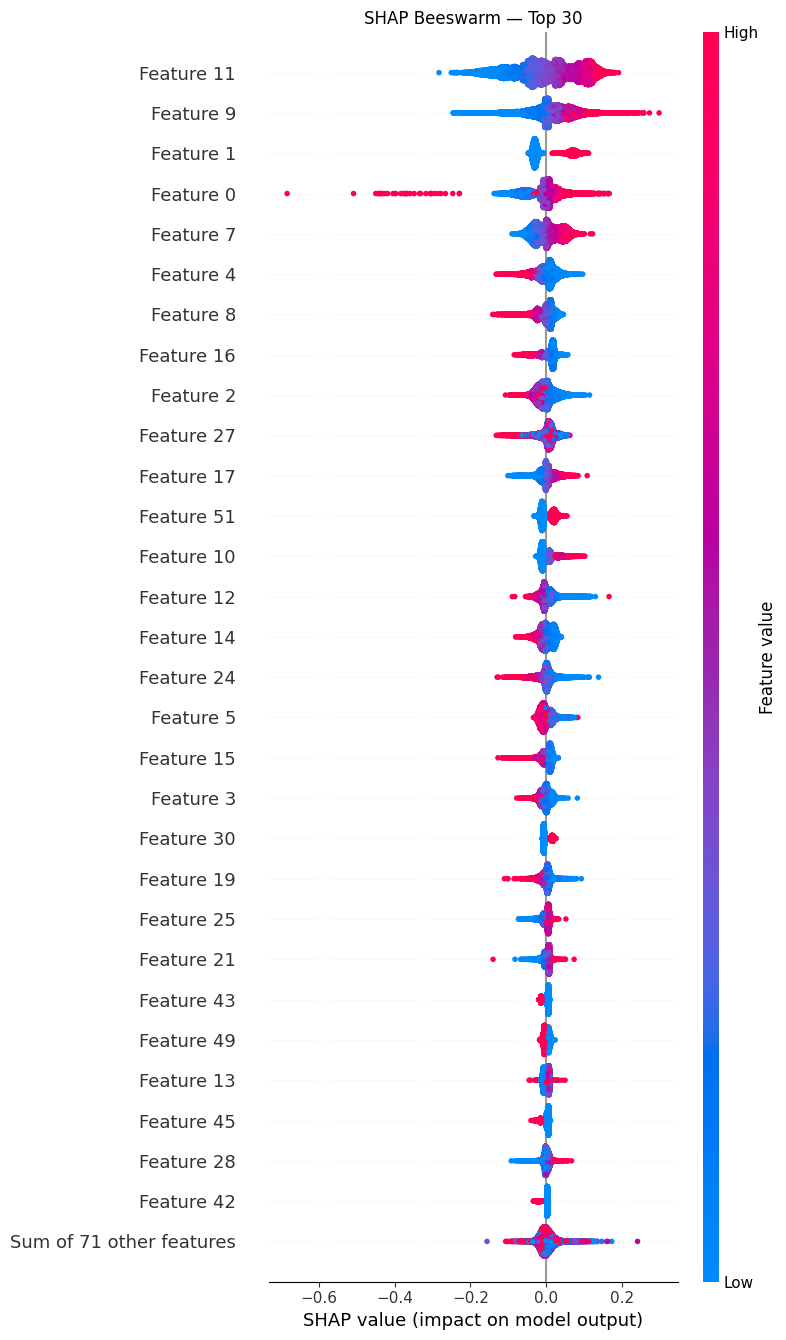

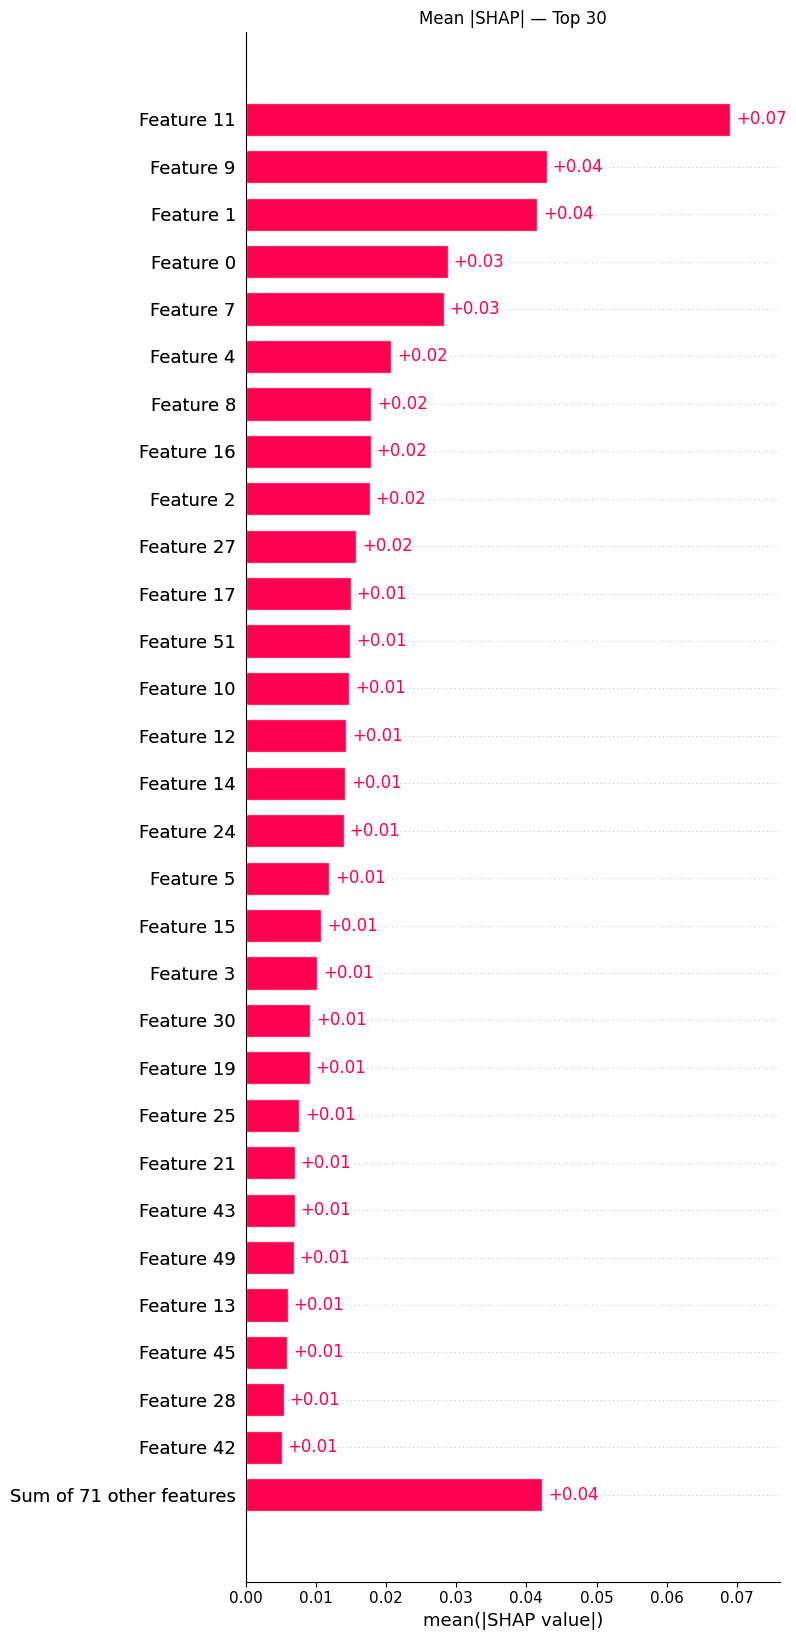

In [19]:

plt.figure()
shap.plots.beeswarm(shap_values, max_display=30, show=False)
plt.title("SHAP Beeswarm — Top 30")
plt.tight_layout()
plt.savefig("outputs_step7/shap_beeswarm_top30.png", dpi=200)
plt.show()

plt.figure()
shap.plots.bar(shap_values, max_display=30, show=False)
plt.title("Mean |SHAP| — Top 30")
plt.tight_layout()
plt.savefig("outputs_step7/shap_bar_top30.png", dpi=200)
plt.show()


## 11) Dependence plots (top features)

In [21]:
import os, numpy as np, matplotlib.pyplot as plt, shap

# --- setup
os.makedirs("outputs_step7", exist_ok=True)

# Support both old (ndarray) and new (Explanation) SHAP objects
vals = shap_values.values if hasattr(shap_values, "values") else np.asarray(shap_values)
names = getattr(shap_values, "feature_names", None)
if names is None:
    # fall back to provided feature_names variable if you have it, else generic
    try:
        names = feature_names
    except NameError:
        names = [f"f{i}" for i in range(vals.shape[1])]

# Use the data SHAP was computed on if available (best), else try X_test/X_val/X_train
if hasattr(shap_values, "data") and shap_values.data is not None:
    X_disp = shap_values.data
else:
    for _n in ("X_eval", "X_test", "X_val", "X_train", "X"):
        if _n in globals():
            X_disp = globals()[_n]
            break
    else:
        raise RuntimeError("Could not find feature matrix for dependence plots.")

# --- rank features by mean |SHAP|
mean_abs = np.abs(vals).mean(axis=0)
topk_idx = np.argsort(mean_abs)[::-1][:10]

# --- save dependence plots
for idx in topk_idx:
    try:
        # Use the classic API: stable across SHAP versions and works with matplotlib
        shap.dependence_plot(
            ind=idx,
            shap_values=vals,
            features=X_disp,
            feature_names=names,
            interaction_index="auto",
            show=False
        )
        plt.title(f"SHAP dependence — {names[idx]}")
        plt.tight_layout()
        safe_name = str(names[idx])[:40].replace("/", "_")
        plt.savefig(f"outputs_step7/dep_{idx}_{safe_name}.png", dpi=200, bbox_inches="tight")
        plt.close()
    except Exception as e:
        print(f"Dependence plot failed for {names[idx]} -> {repr(e)}")


## 12) Local explanations — Waterfall plots

Waterfall indices: [12243, 23032, 24583, 385, 17058]


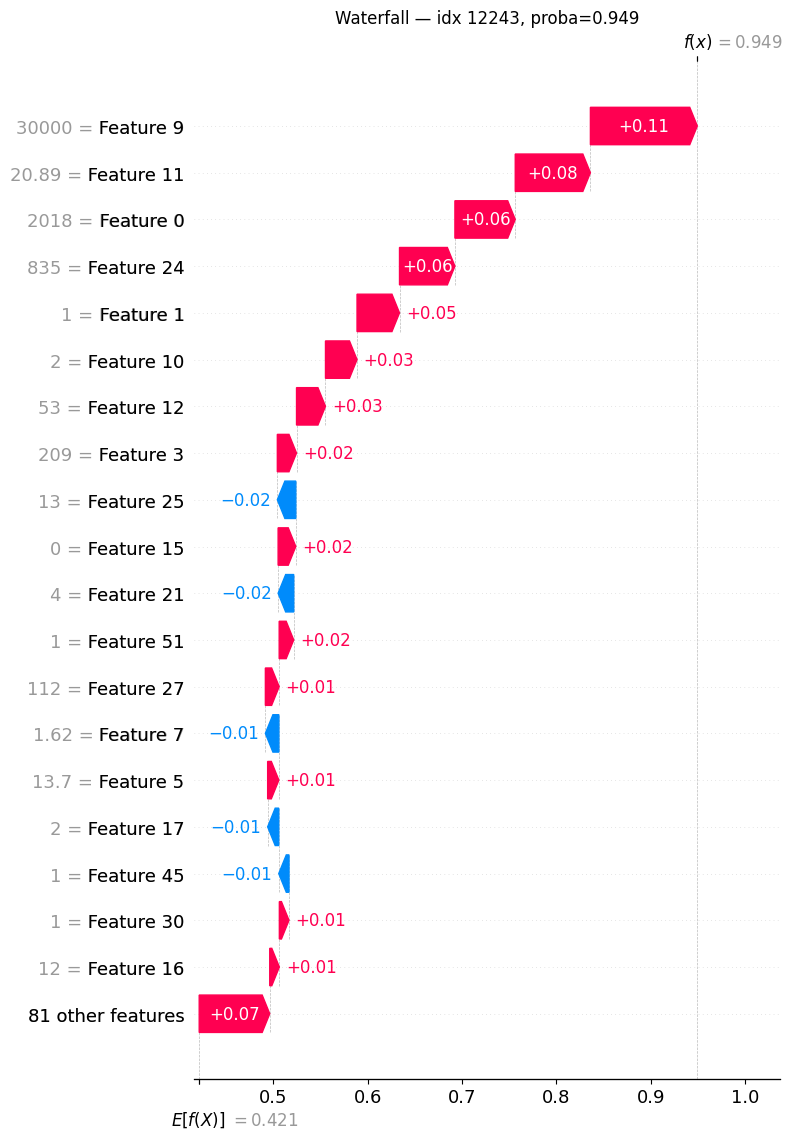

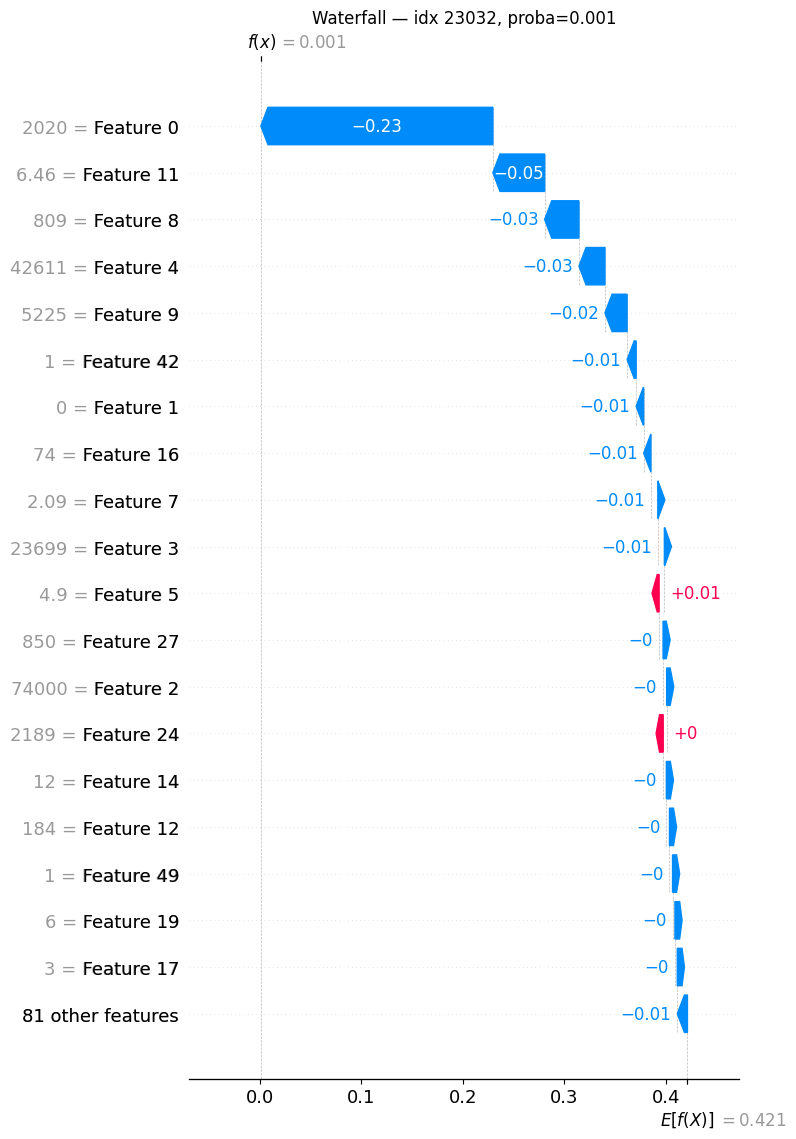

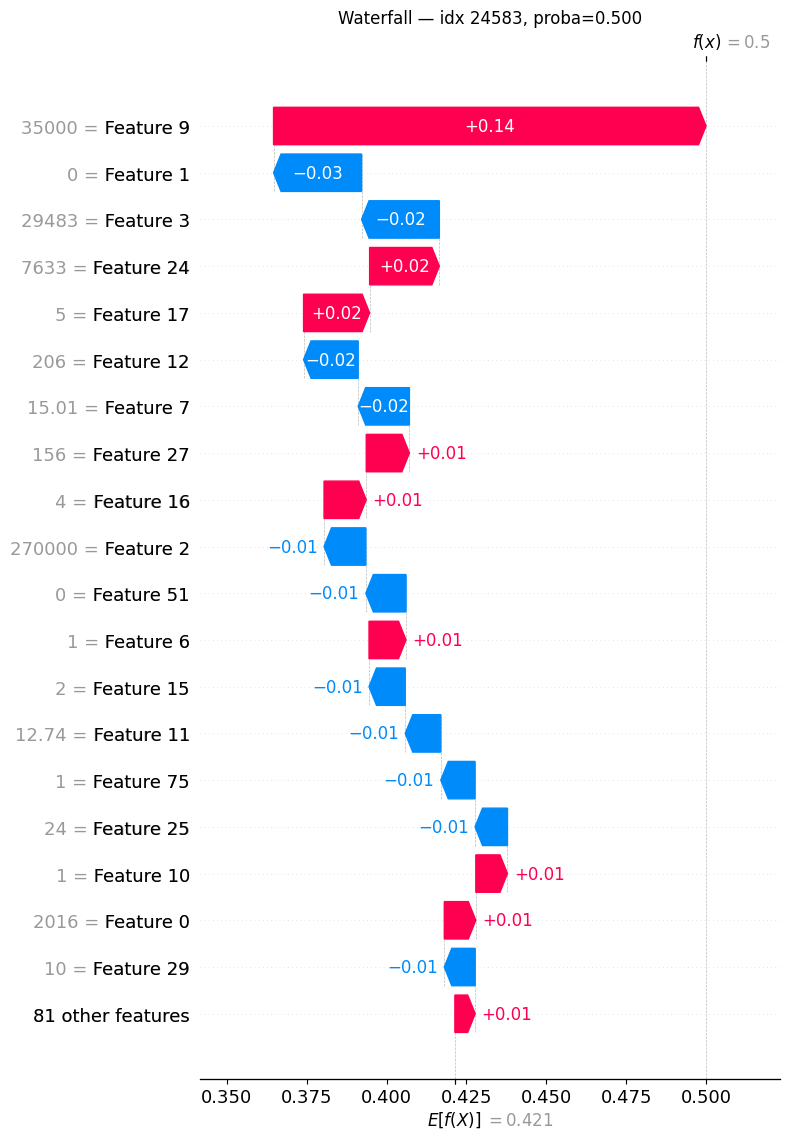

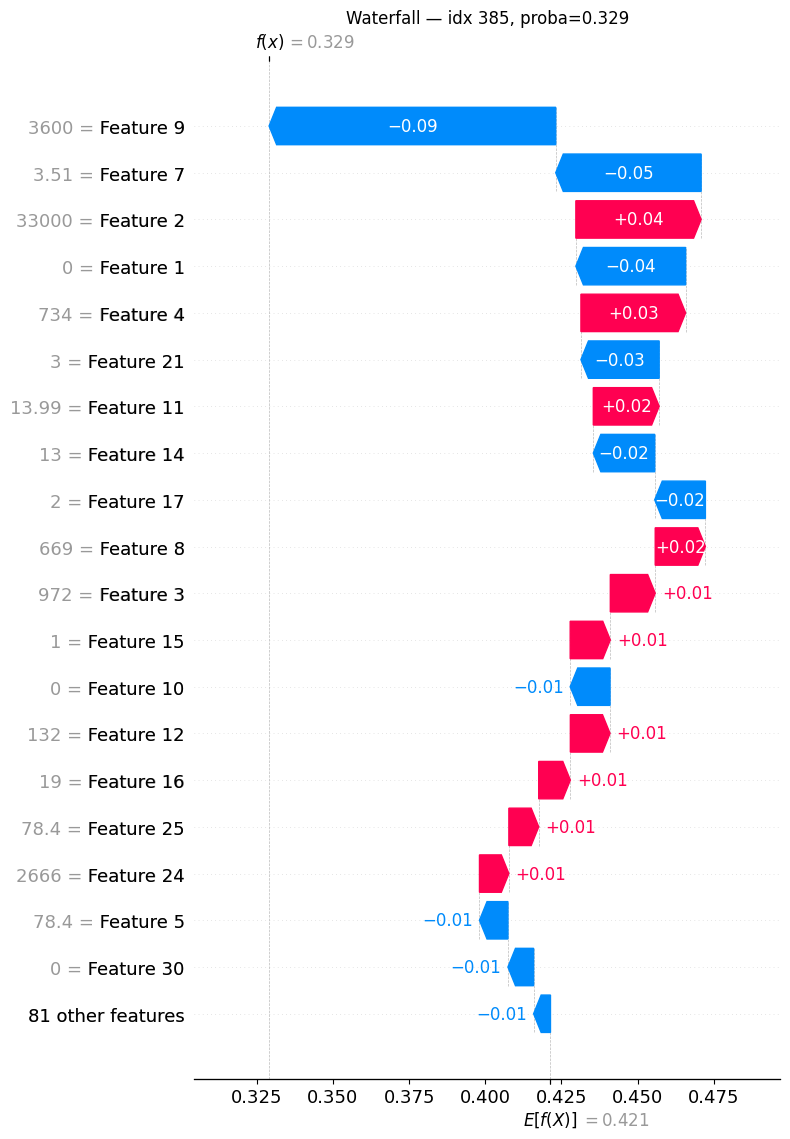

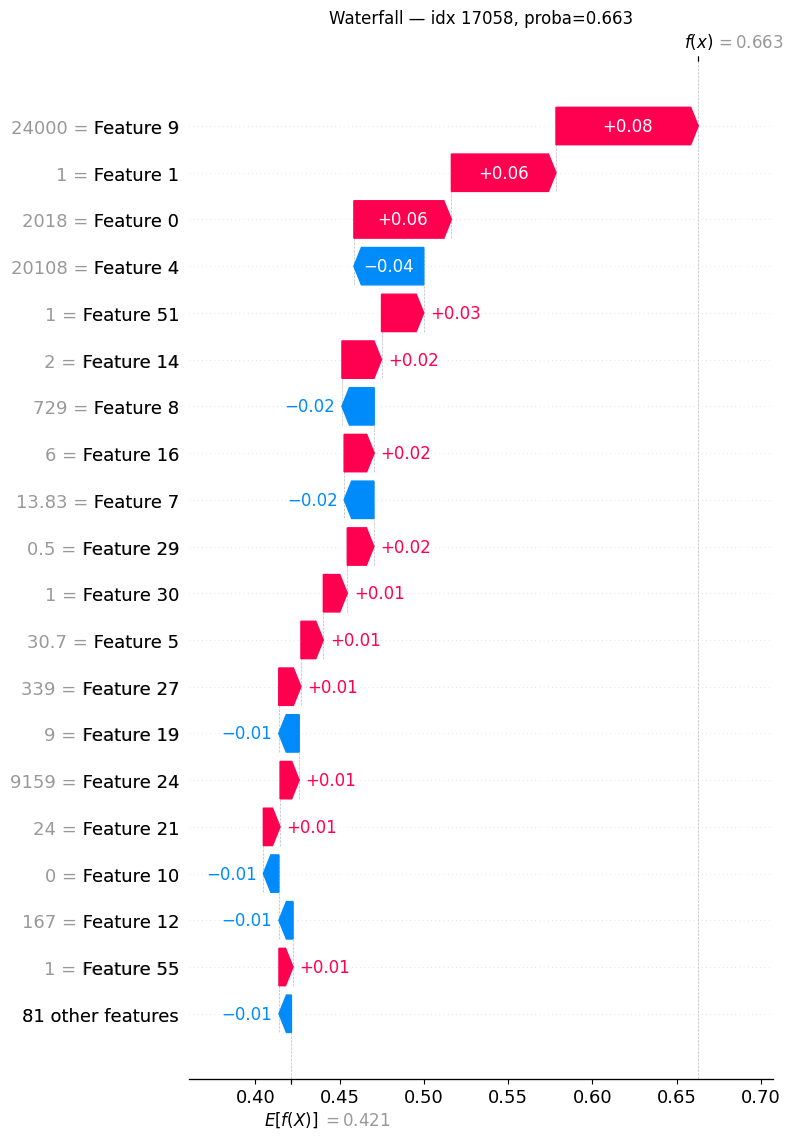

In [22]:

# Pick a few representative cases: highest/lowest/borderline + randoms
ix_max = int(np.argmax(proba))
ix_min = int(np.argmin(proba))
# pick one close to 0.5 if possible
dif = np.abs(proba - 0.5)
ix_mid = int(np.argmin(dif))

candidates = sorted(set([ix_max, ix_min, ix_mid]))
# add a couple of random indices
rng = np.random.default_rng(123)
rand_extra = rng.choice(X_t.shape[0], size=min(2, X_t.shape[0]), replace=False).tolist()
for ix in rand_extra:
    if ix not in candidates:
        candidates.append(int(ix))

print("Waterfall indices:", candidates)

for ix in candidates:
    try:
        shap.plots.waterfall(shap_values[ix], max_display=20, show=False)
        plt.title(f"Waterfall — idx {ix}, proba={proba[ix]:.3f}")
        plt.tight_layout()
        plt.savefig(f"outputs_step7/waterfall_idx{ix}.png", dpi=200)
        plt.show()
    except Exception as e:
        print("Waterfall failed for idx", ix, "->", repr(e))


## 13) Save global SHAP CSVs

In [23]:

# (a) mean |SHAP| per expanded feature
import pandas as pd
sv_df = pd.DataFrame(shap_values.values, columns=feature_names)
mean_abs = sv_df.abs().mean().sort_values(ascending=False)
mean_abs.to_csv("outputs_step7/global_mean_abs_shap_expanded.csv", header=["mean_abs_shap"])

print("Saved: outputs_step7/global_mean_abs_shap_expanded.csv")

# (b) Optional: aggregate OHE back to original categorical names (sum of |SHAP| across levels)
agg = {}
for f in feature_names:
    # heuristic: OneHotEncoder names look like "feature_category"
    base = f.split("_", 1)[0] if "_" in f else f
    agg.setdefault(base, 0.0)
    agg[base] += mean_abs.get(f, 0.0)

agg = pd.Series(agg).sort_values(ascending=False)
agg.to_csv("outputs_step7/global_mean_abs_shap_grouped.csv", header=["grouped_mean_abs_shap"])
print("Saved: outputs_step7/global_mean_abs_shap_grouped.csv")


Saved: outputs_step7/global_mean_abs_shap_expanded.csv
Saved: outputs_step7/global_mean_abs_shap_grouped.csv
